In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import fenics as dl

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from Drone import Drone as Drone

from DetectorApprox import Convolution as Conv

from NavigationCircle import NavigationCircle as Navigation
from NavigationFreePath import NavigationFreePath as Navigation
from OEDUtility import OEDUtility

import cyipopt

%load_ext autoreload
%autoreload 2

import time
tStart_notebook = time.time()

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

# fom = FOM(mesh_shape='houses', polyDim=2, meshDim=50)
fom = FOM(mesh_shape='square', polyDim=2, meshDim=50)

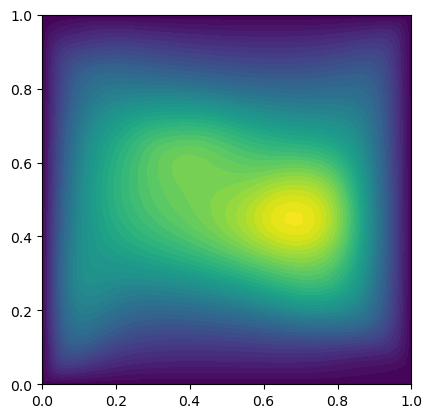

In [3]:
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)
fom.plot(state);

# Pointwise

In [4]:
from DetectorPointwise import DetectorPointwise as Detector

In [5]:
N = 300
x = np.linspace(0.0, 1.0, N)
y = np.linspace(0.0, 1.0, N)
grid_t = np.array([0.0])

conv = Conv(fom, state, mode = "pointwise", resolution = 100, debug = True)

class dummy_flight:
    def __init__(self, x, y):
        self.flightpath = np.array([[x,y]])
        self.grid_t = np.array([0.0])

S = np.zeros((x.shape[0], y.shape[0]))
S_approx = np.zeros((x.shape[0], y.shape[0]))

Sx = np.zeros((x.shape[0], y.shape[0]))
Sy = np.zeros((x.shape[0], y.shape[0]))
Sx_approx = np.zeros((x.shape[0], y.shape[0]))
Sy_approx = np.zeros((x.shape[0], y.shape[0]))

for i, xx in enumerate(x):
    for j, yy in enumerate(y):
        flight = dummy_flight(xx,yy)
        S[i,j] = Detector().measure(flight, state)
        S_approx[i,j] = conv(np.array([[xx, yy]]))

        Sx[i,j], Sy[i,j] = tuple(Detector().d_measurement_d_position(flight, state)[0])
        Sx_approx[i,j], Sy_approx[i,j] = tuple(conv.grad(np.array([[xx, yy]]))[0])

sampling the state
done sampling state
convolving the state
building interpolator


/tmp/ipykernel_1951789/3849991794.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[i,j] = Detector().measure(flight, state)
/tmp/ipykernel_1951789/3849991794.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_approx[i,j] = conv(np.array([[xx, yy]]))


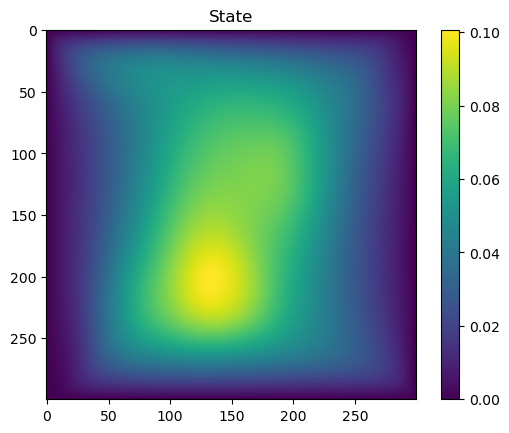

In [6]:
plt.figure()
plt.title("State")
plt.imshow(np.abs(S))
plt.colorbar()

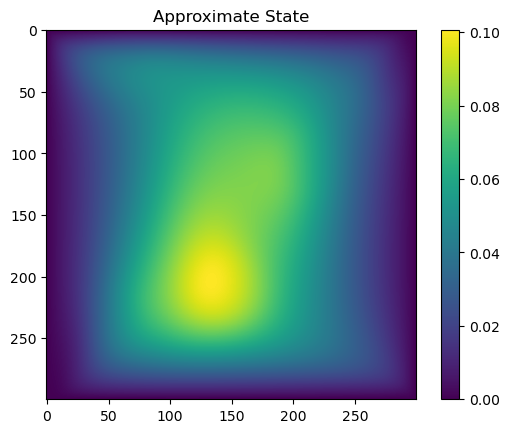

In [7]:
plt.figure()
plt.title("Approximate State")
plt.imshow(np.abs(S_approx))
plt.colorbar()

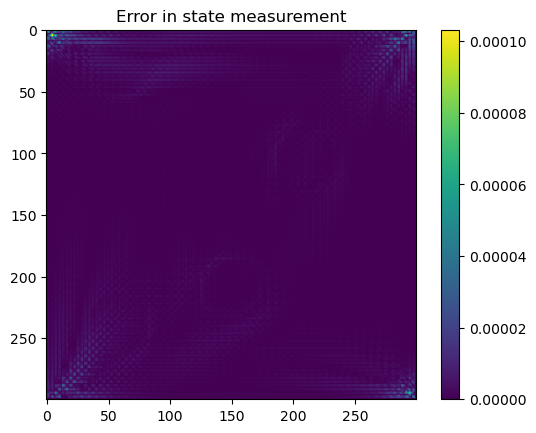

In [8]:
plt.figure()
plt.title("Error in state measurement")
plt.imshow(np.abs(S - S_approx))
plt.colorbar()

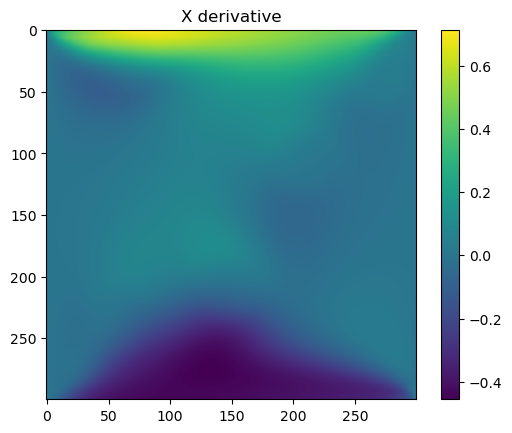

In [9]:
plt.figure()
plt.title("X derivative")
plt.imshow(Sx)
plt.colorbar()

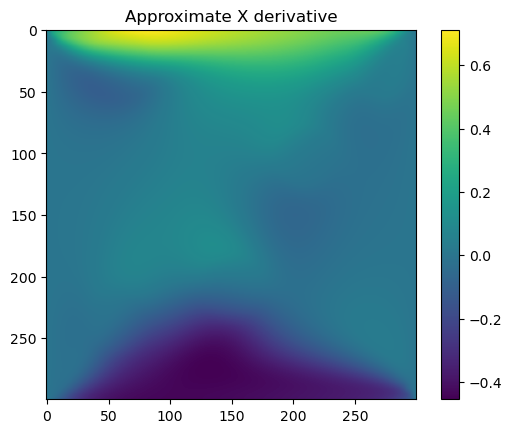

In [10]:
plt.figure()
plt.title("Approximate X derivative")
plt.imshow(Sx_approx)
plt.colorbar()

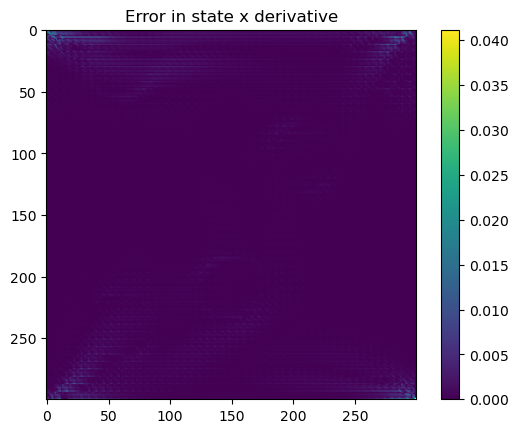

In [11]:
plt.figure()
plt.title("Error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx))
plt.colorbar()

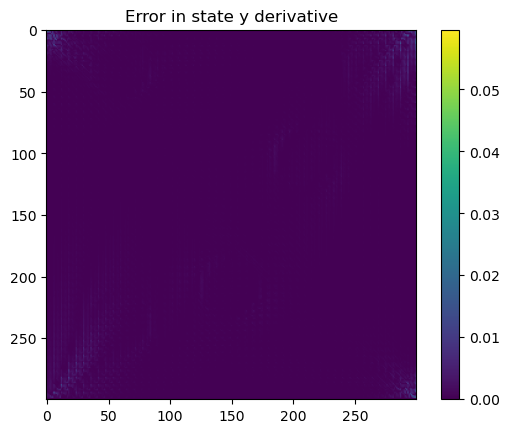

In [12]:
plt.figure()
plt.title("Error in state y derivative")
plt.imshow(np.abs(Sy - Sy_approx))
plt.colorbar()

# Gaussian

In [13]:
from DetectorGaussian import DetectorGaussian as Detector

In [14]:
N = 300
x = np.linspace(0.0, 1.0, N)
y = np.linspace(0.0, 1.0, N)
grid_t = np.array([0.0])

conv = Conv(fom, state, mode = "gaussian", resolution = 100, debug = True, sigma = 0.1)
detector = Detector(fom, sigma = 0.1)

class dummy_flight:
    def __init__(self, x, y):
        self.flightpath = np.array([[x,y]])
        self.grid_t = np.array([0.0])

S = np.zeros((x.shape[0], y.shape[0]))
S_approx = np.zeros((x.shape[0], y.shape[0]))

Sx = np.zeros((x.shape[0], y.shape[0]))
Sy = np.zeros((x.shape[0], y.shape[0]))
Sx_approx = np.zeros((x.shape[0], y.shape[0]))
Sy_approx = np.zeros((x.shape[0], y.shape[0]))

for i, xx in enumerate(x):
    for j, yy in enumerate(y):
        flight = dummy_flight(xx,yy)
        S[i,j] = detector.measure(flight, state)
        S_approx[i,j] = conv(np.array([[xx, yy]]))

        Sx[i,j], Sy[i,j] = tuple(detector.d_measurement_d_position(flight, state)[0])
        Sx_approx[i,j], Sy_approx[i,j] = tuple(conv.grad(np.array([[xx, yy]]))[0])

sampling the state
done sampling state
convolving the state
building interpolator


/tmp/ipykernel_1951789/1320504642.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[i,j] = detector.measure(flight, state)
/tmp/ipykernel_1951789/1320504642.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_approx[i,j] = conv(np.array([[xx, yy]]))


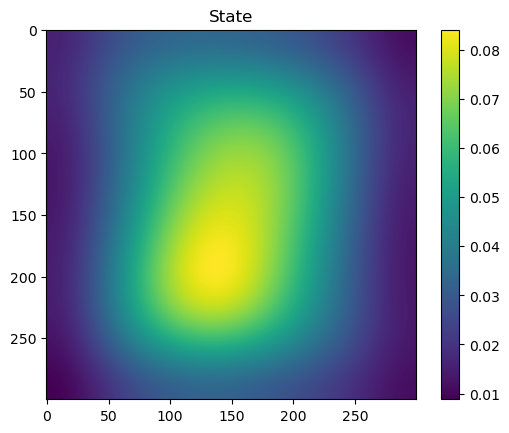

In [15]:
plt.figure()
plt.title("State")
plt.imshow(np.abs(S))
plt.colorbar()

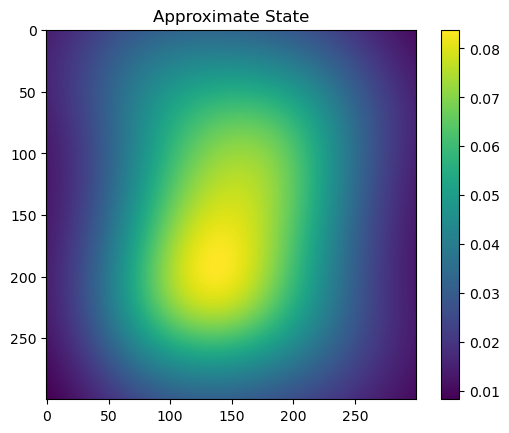

In [16]:
plt.figure()
plt.title("Approximate State")
plt.imshow(np.abs(S_approx))
plt.colorbar()

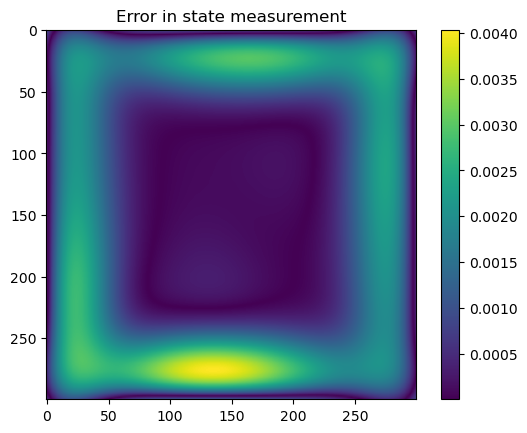

In [17]:
plt.figure()
plt.title("Error in state measurement")
plt.imshow(np.abs(S - S_approx))
plt.colorbar()

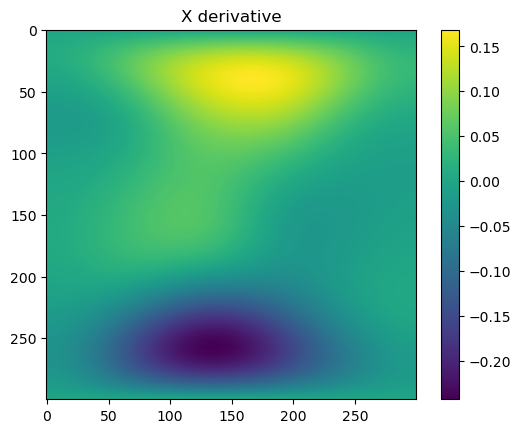

In [18]:
plt.figure()
plt.title("X derivative")
plt.imshow(Sx)
plt.colorbar()

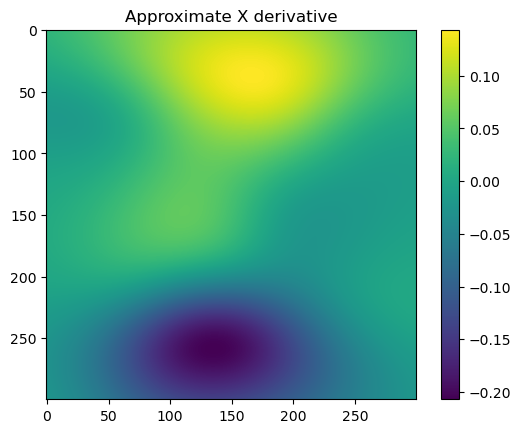

In [19]:
plt.figure()
plt.title("Approximate X derivative")
plt.imshow(Sx_approx)
plt.colorbar()

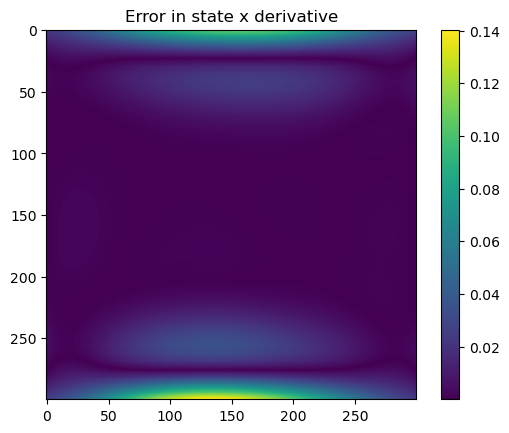

In [20]:
plt.figure()
plt.title("Error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx))
plt.colorbar()

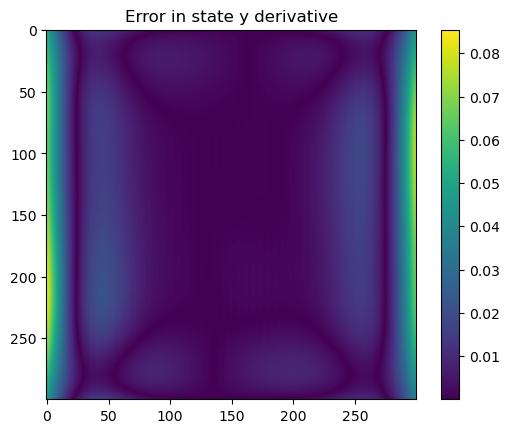

In [21]:
plt.figure()
plt.title("Error in state y derivative")
plt.imshow(np.abs(Sy - Sy_approx))
plt.colorbar()

# Truncated Gaussian

In [28]:
from DetectorTruncGaussian import DetectorTruncGaussian as Detector
from tqdm.notebook import tqdm

In [52]:
N = 50
# Need to avoid boundaries for this one...
x = np.linspace(0.2, 0.8, N)
y = np.linspace(0.2, 0.8, N)
grid_t = np.array([0.0])

conv = Conv(fom, state, mode = "truncgaussian", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)
detector = Detector(fom, sigma = 0.1, radius = 0.2)

class dummy_flight:
    def __init__(self, x, y):
        self.flightpath = np.array([[x,y]])
        self.grid_t = np.array([0.0])
        self.alpha = None

S = np.zeros((x.shape[0], y.shape[0]))
S_approx = np.zeros((x.shape[0], y.shape[0]))

Sx = np.zeros((x.shape[0], y.shape[0]))
Sy = np.zeros((x.shape[0], y.shape[0]))
Sx_approx = np.zeros((x.shape[0], y.shape[0]))
Sy_approx = np.zeros((x.shape[0], y.shape[0]))

for i, xx in enumerate(tqdm(x)):
    for j, yy in enumerate(y):
        flight = dummy_flight(xx,yy)
        S[i,j] = detector.measure(flight, state)
        S_approx[i,j] = conv(np.array([[xx, yy]]))

        Sx[i,j], Sy[i,j] = tuple(detector.d_measurement_d_position(flight, state)[0])
        Sx_approx[i,j], Sy_approx[i,j] = tuple(conv.grad(np.array([[xx, yy]]))[0])

sampling the state
done sampling state
convolving the state
building interpolator


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1951789/483553829.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[i,j] = detector.measure(flight, state)
/tmp/ipykernel_1951789/483553829.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_approx[i,j] = conv(np.array([[xx, yy]]))


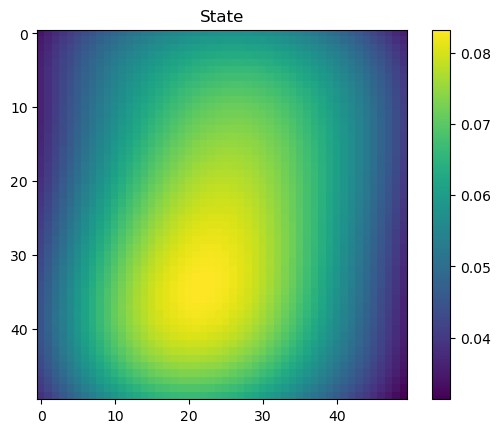

In [53]:
plt.figure()
plt.title("State")
plt.imshow(np.abs(S))
plt.colorbar()

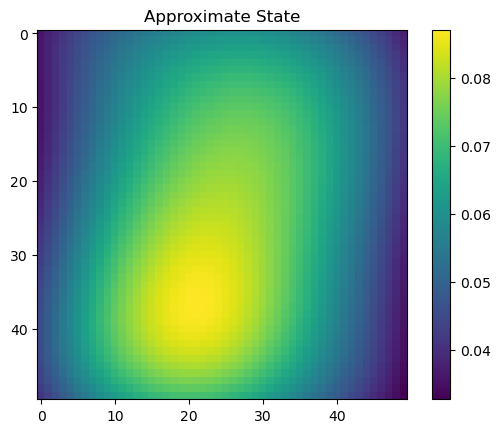

In [54]:
plt.figure()
plt.title("Approximate State")
plt.imshow(np.abs(S_approx))
plt.colorbar()

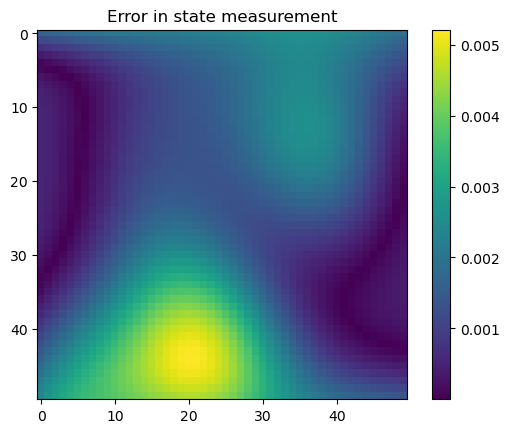

In [55]:
plt.figure()
plt.title("Error in state measurement")
plt.imshow(np.abs(S - S_approx))
plt.colorbar()

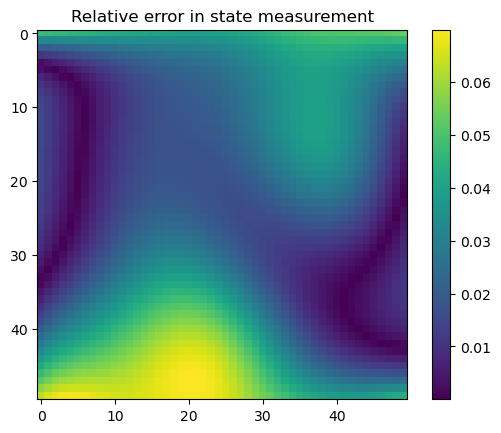

In [56]:
plt.figure()
plt.title("Relative error in state measurement")
plt.imshow(np.abs(S - S_approx) / np.abs(S))
plt.colorbar()

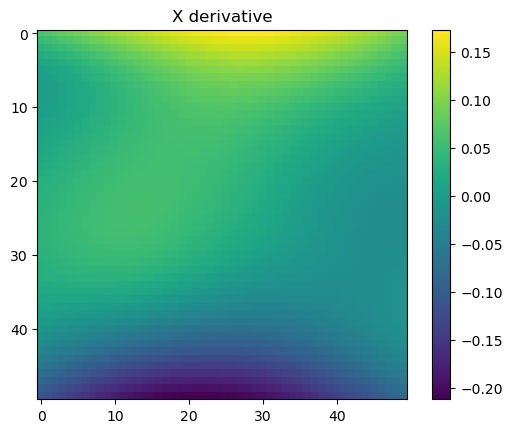

In [57]:
plt.figure()
plt.title("X derivative")
plt.imshow(Sx)
plt.colorbar()

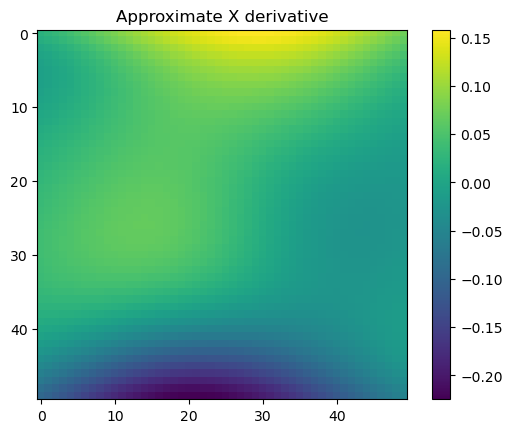

In [58]:
plt.figure()
plt.title("Approximate X derivative")
plt.imshow(Sx_approx)
plt.colorbar()

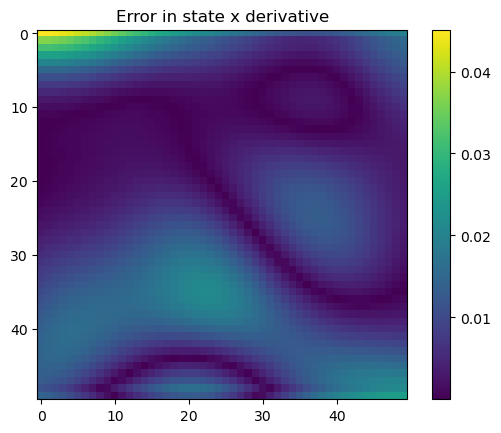

In [59]:
plt.figure()
plt.title("Error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx))
plt.colorbar()

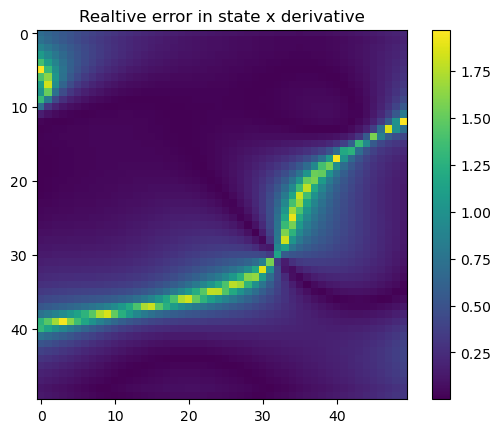

In [60]:
plt.figure()
plt.title("Realtive error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx)/np.maximum(np.abs(Sx_approx), np.abs(Sx)))
plt.colorbar()

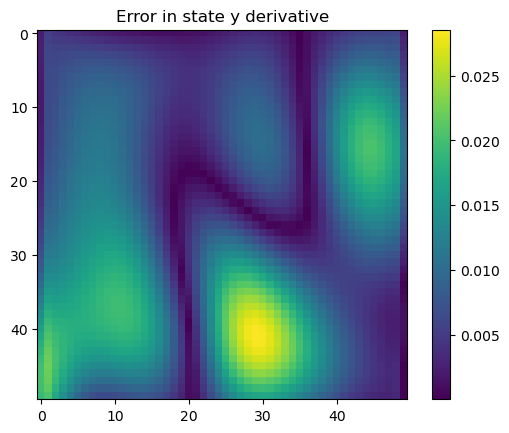

In [61]:
plt.figure()
plt.title("Error in state y derivative")
plt.imshow(np.abs(Sy - Sy_approx))
plt.colorbar()

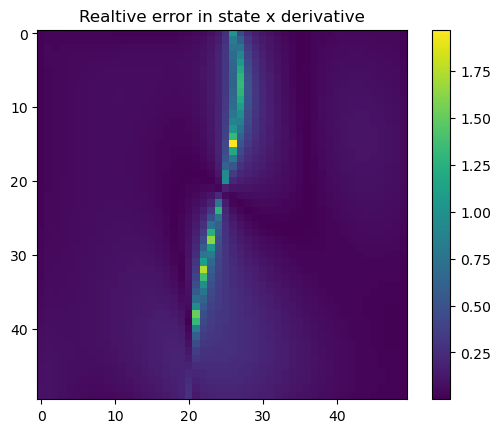

In [62]:
plt.figure()
plt.title("Realtive error in state x derivative")
plt.imshow(np.abs(Sy - Sy_approx)/np.maximum(np.abs(Sy_approx), np.abs(Sy)))
plt.colorbar()

# Uniform

In [63]:
from DetectorUniform import DetectorUniform as Detector
from tqdm.notebook import tqdm

In [76]:
N = 50
# Need to avoid boundaries for this one...
x = np.linspace(0.2, 0.8, N)
y = np.linspace(0.2, 0.8, N)
grid_t = np.array([0.0])

conv = Conv(fom, state, mode = "uniform", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)
detector = Detector(fom, sigma = 0.1, radius = 0.2)

class dummy_flight:
    def __init__(self, x, y):
        self.flightpath = np.array([[x,y]])
        self.grid_t = np.array([0.0])
        self.alpha = None

S = np.zeros((x.shape[0], y.shape[0]))
S_approx = np.zeros((x.shape[0], y.shape[0]))

Sx = np.zeros((x.shape[0], y.shape[0]))
Sy = np.zeros((x.shape[0], y.shape[0]))
Sx_approx = np.zeros((x.shape[0], y.shape[0]))
Sy_approx = np.zeros((x.shape[0], y.shape[0]))

for i, xx in enumerate(tqdm(x)):
    for j, yy in enumerate(y):
        flight = dummy_flight(xx,yy)
        S[i,j] = detector.measure(flight, state)
        S_approx[i,j] = conv(np.array([[xx, yy]]))

        Sx[i,j], Sy[i,j] = tuple(detector.d_measurement_d_position(flight, state)[0])
        Sx_approx[i,j], Sy_approx[i,j] = tuple(conv.grad(np.array([[xx, yy]]))[0])

sampling the state
done sampling state
convolving the state
building interpolator


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1951789/4082167720.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[i,j] = detector.measure(flight, state)
/tmp/ipykernel_1951789/4082167720.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_approx[i,j] = conv(np.array([[xx, yy]]))


/home/tlynn/m2dtIceSheet/notebooks/../models/AdvectionDiffusion/Detectors/DetectorApprox.py:240: SyntaxWarning: invalid escape sequence '\i'
  """


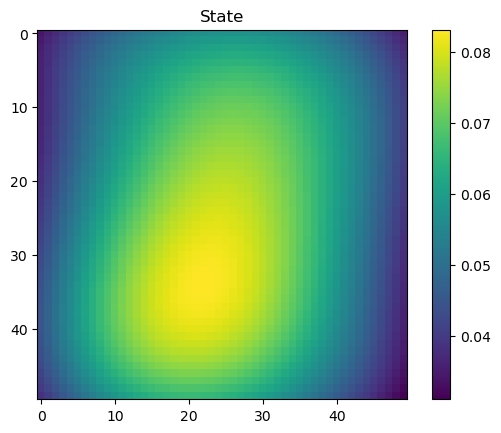

In [77]:
plt.figure()
plt.title("State")
plt.imshow(np.abs(S))
plt.colorbar()

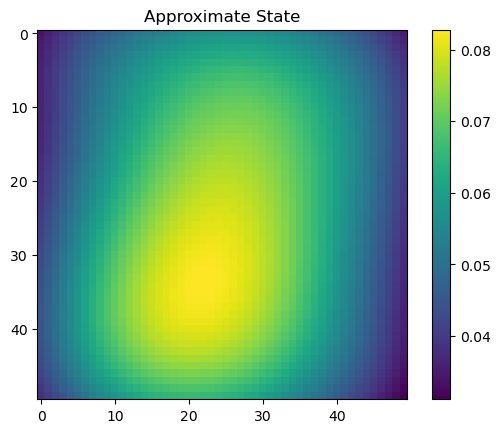

In [78]:
plt.figure()
plt.title("Approximate State")
plt.imshow(np.abs(S_approx))
plt.colorbar()

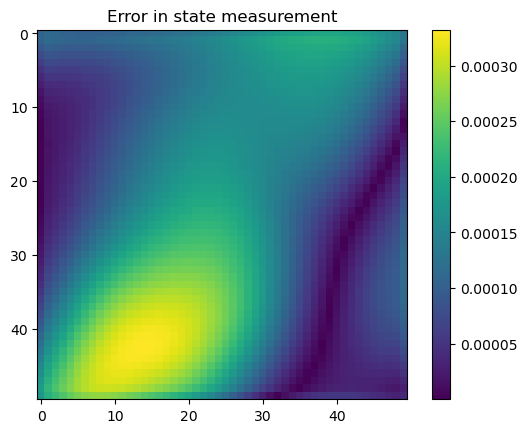

In [79]:
plt.figure()
plt.title("Error in state measurement")
plt.imshow(np.abs(S - S_approx))
plt.colorbar()

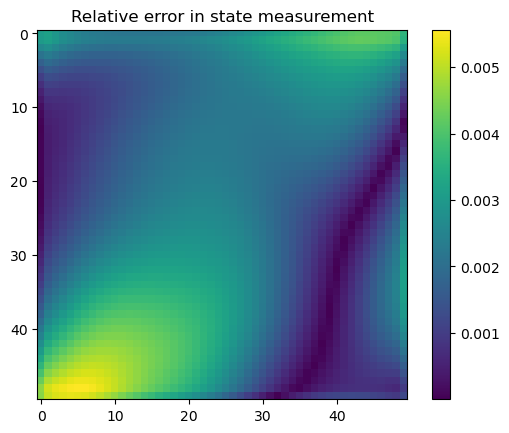

In [80]:
plt.figure()
plt.title("Relative error in state measurement")
plt.imshow(np.abs(S - S_approx) / np.abs(S))
plt.colorbar()

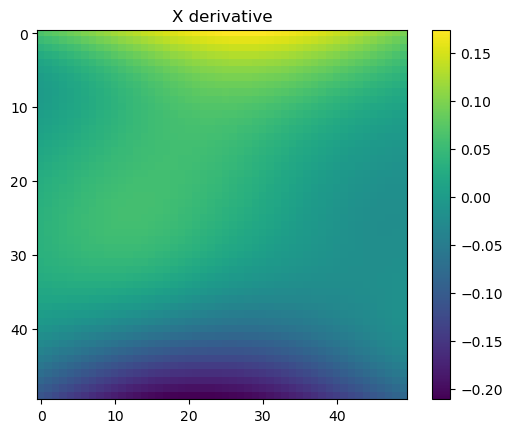

In [81]:
plt.figure()
plt.title("X derivative")
plt.imshow(Sx)
plt.colorbar()

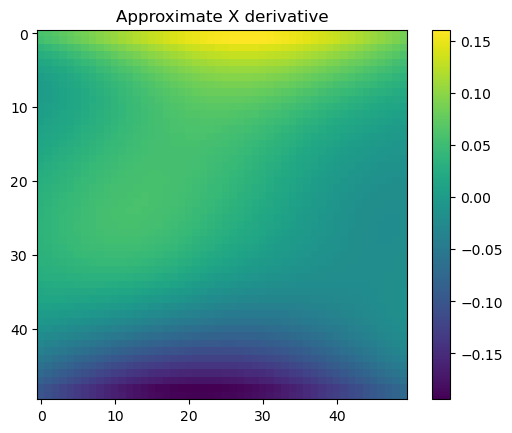

In [82]:
plt.figure()
plt.title("Approximate X derivative")
plt.imshow(Sx_approx)
plt.colorbar()

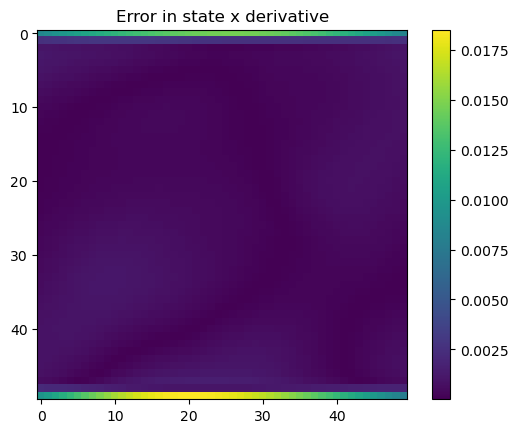

In [83]:
plt.figure()
plt.title("Error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx))
plt.colorbar()

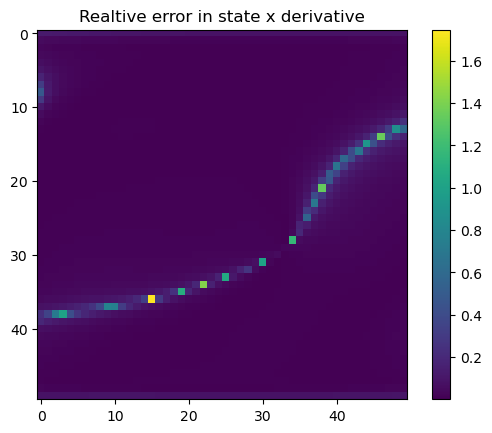

In [84]:
plt.figure()
plt.title("Realtive error in state x derivative")
plt.imshow(np.abs(Sx - Sx_approx)/np.maximum(np.abs(Sx_approx), np.abs(Sx)))
plt.colorbar()

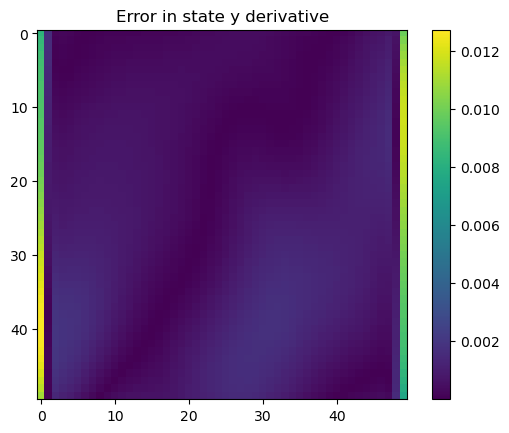

In [85]:
plt.figure()
plt.title("Error in state y derivative")
plt.imshow(np.abs(Sy - Sy_approx))
plt.colorbar()

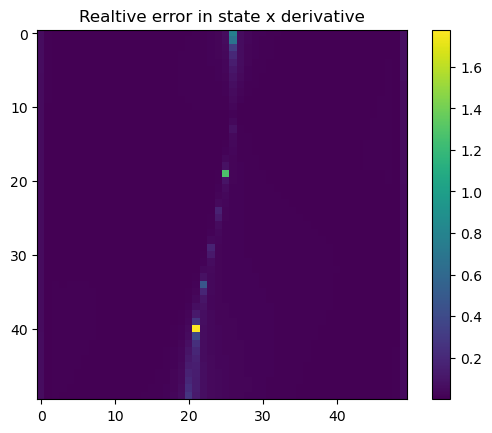

In [86]:
plt.figure()
plt.title("Realtive error in state x derivative")
plt.imshow(np.abs(Sy - Sy_approx)/np.maximum(np.abs(Sy_approx), np.abs(Sy)))
plt.colorbar()

In [96]:
from DetectorPointwise import DetectorPointwise as Detector_pointwise

N = 50
# Need to avoid boundaries for this one...
x = np.linspace(0.2, 0.8, N)
y = np.linspace(0.2, 0.8, N)
grid_t = np.array([0.0])

detector_pointwise = Detector_pointwise(fom, sigma = 0.1, radius = 0.2)

S_pointwise = np.zeros((x.shape[0], y.shape[0]))

Sx_pointwise = np.zeros((x.shape[0], y.shape[0]))
Sy_pointwise = np.zeros((x.shape[0], y.shape[0]))

class dummy_flight:
    def __init__(self, x, y):
        self.flightpath = np.array([[x,y]])
        self.grid_t = np.array([0.0])
        self.alpha = None

for i, xx in enumerate(tqdm(x)):
    for j, yy in enumerate(y):
        flight = dummy_flight(xx,yy)
        S_pointwise[i,j] = detector_pointwise.measure(flight, state)

        Sx_pointwise[i,j], Sy_pointwise[i,j] = tuple(detector_pointwise.d_measurement_d_position(flight, state)[0])

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1951789/1274890812.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_pointwise[i,j] = detector_pointwise.measure(flight, state)


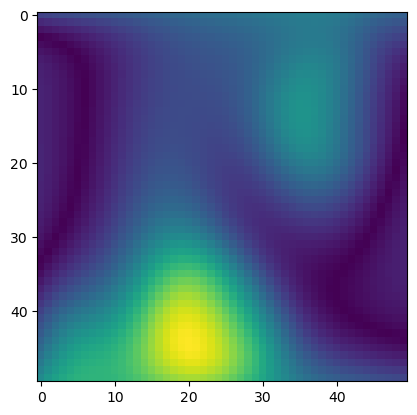

In [97]:
plt.figure()
plt.imshow(np.abs(S - S_pointwise))

# Approximation comparisons

In [87]:
N = 500
# Need to avoid boundaries for this one...
x = np.linspace(0.0, 1.0, N)
y = np.linspace(0.0, 1.0, N)
grid_t = np.array([0.0])

conv_truncgaussian = Conv(fom, state, mode = "truncgaussian", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)
conv_pointwise = Conv(fom, state, mode = "pointwise", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)
conv_uniform = Conv(fom, state, mode = "uniform", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)
conv_gaussian = Conv(fom, state, mode = "gaussian", resolution = 100, debug = True, sigma = 0.1, radius = 0.2)

S_truncgaussian = np.zeros((x.shape[0], y.shape[0]))
S_pointwise = np.zeros((x.shape[0], y.shape[0]))
S_uniform = np.zeros((x.shape[0], y.shape[0]))
S_gaussian = np.zeros((x.shape[0], y.shape[0]))

for i, xx in enumerate(tqdm(x)):
    for j, yy in enumerate(y):
        S_truncgaussian[i,j] = conv_truncgaussian(np.array([[xx, yy]]))
        S_pointwise[i,j] = conv_pointwise(np.array([[xx, yy]]))
        S_uniform[i,j] = conv_uniform(np.array([[xx, yy]]))
        S_gaussian[i,j] = conv_gaussian(np.array([[xx, yy]]))
        # Sx_approx[i,j], Sy_approx[i,j] = tuple(conv.grad(np.array([[xx, yy]]))[0])

sampling the state
done sampling state
convolving the state
building interpolator
sampling the state
done sampling state
convolving the state
building interpolator
sampling the state
done sampling state
convolving the state
building interpolator
sampling the state
done sampling state
convolving the state
building interpolator


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1951789/306683599.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_truncgaussian[i,j] = conv_truncgaussian(np.array([[xx, yy]]))
/tmp/ipykernel_1951789/306683599.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_pointwise[i,j] = conv_pointwise(np.array([[xx, yy]]))
/tmp/ipykernel_1951789/306683599.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_uniform[i,j] = conv_uniform(np.array([[xx, yy]]))
/tmp/ipykernel_1951789/306683599.py:22:

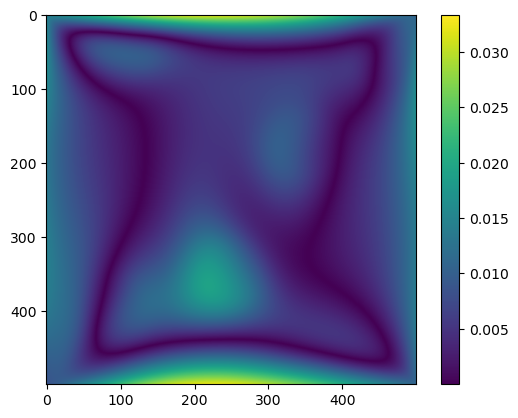

In [91]:
plt.figure()
plt.imshow(np.abs(S_pointwise - S_gaussian))
plt.colorbar()

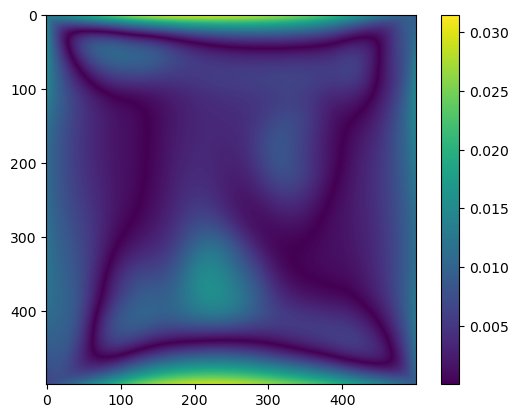

In [92]:
plt.figure()
plt.imshow(np.abs(S_pointwise - S_truncgaussian))
plt.colorbar()

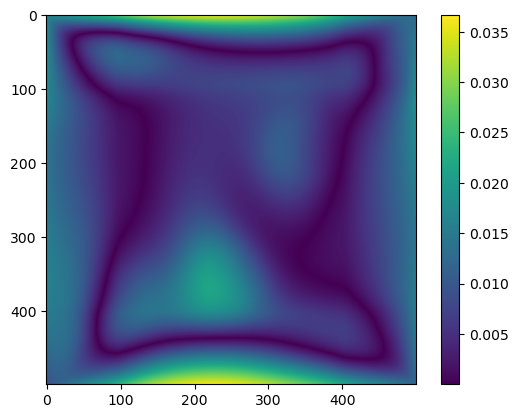

In [93]:
plt.figure()
plt.imshow(np.abs(S_pointwise - S_uniform))
plt.colorbar()

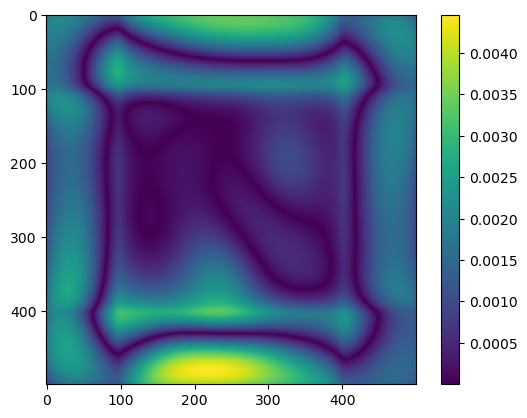

In [94]:
plt.figure()
plt.imshow(np.abs(S_gaussian - S_uniform))
plt.colorbar()

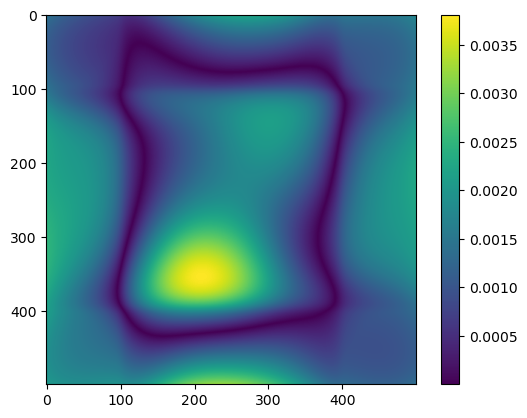

In [95]:
plt.figure()
plt.imshow(np.abs(S_gaussian - S_truncgaussian))
plt.colorbar()